In [1]:
import torch
import torchaudio
from IPython.display import Audio
from torch.utils.data import DataLoader
import os
import pandas as pd
import torchaudio
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter


#


# %%
class CustomAudioDataset(Dataset):
    def __init__(self, tsv_path, clips_dir, config):
        self.data = pd.read_csv(tsv_path, sep='\t')
        self.clips_dir = clips_dir
        self.config = config  # Configurations for MFCC transformation
        self.char_to_num = config['char_to_num']  # Character to number mapping

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['path'] + '.mp3'
        label_str = self.data.iloc[idx]['sentence']

        # Convert label string to numbers using char_to_num mapping
        label_nums = torch.tensor([self.char_to_num[c] for c in label_str if c in self.char_to_num])

        audio_file = os.path.join(self.clips_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_file)

        # Perform MFCC transformation
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate, n_mfcc=self.config['mfcc_bins'],
            melkwargs={"n_fft": int(sample_rate * self.config['win_length_ms'] // 1000),
                       "hop_length": int(sample_rate * self.config['step_length_ms'] // 1000),
                       "n_mels": config['mfcc_bins']}
        )
        mfcc_features = mfcc_transform(waveform).squeeze().T  # [t x f]
        seq_length = mfcc_features.size(0)  # Number of MFCC time steps
        target_length = len(label_nums)  # Length of label_nums


        #return mfcc_features, label_nums, os.path.join(self.clips_dir, filename), label_str
        return mfcc_features, label_nums, seq_length, target_length, os.path.join(self.clips_dir, filename), waveform, label_str


In [2]:
config = {
    'sampling_rate': 16000,
    'win_length_ms': 32,
    'step_length_ms': 20,
    'mfcc_bins': 26,
    'batch_size': 32
}

# Define the character-to-number mapping with space as 0 and ' as the last number
char_to_num = {
    ' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9,
    'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18,
    's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, "'": 27
}
num_to_char = {v: k for k, v in char_to_num.items()}

config['char_to_num'] = char_to_num
config['num_to_char'] = num_to_char

#network config
# Update the existing config dictionary with the specified values
config.update({
    'n_hidden_1': 2048,
    'n_hidden_2': 2048,
    'n_hidden_3': 2048,
    'n_hidden_5': 2048,
    'n_hidden_6': len(char_to_num)+1,
    'n_cell_dim': 2048,
    'dropout': [0.0] * 6,  # Assuming 6 dropout rates are needed
    'overlap': True,
    'layer_norm': False,
    'n_input': 26,
    'n_context': 9
})

# training config
config.update({
    'gpus': 4,
    'learning_rate':0.1,
    'cpus':16,
    'max_epoch': 100,
    'half_precision': False,  # Enable half precision

})

tsv_path = '/scratch/f006pq6/datasets/commonvoice_v2/train.tsv'
clips_dir = '/scratch/f006pq6/datasets/commonvoice_v2/clips'
dataset = CustomAudioDataset(tsv_path, clips_dir, config)



In [7]:

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

n_fft = 512
win_length = 512
hop_length = 320
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=26,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": 40,
        "hop_length": 320,
    },
)

mfcc = mfcc_transform(dataset[4][-2])

1.13.0+cu117
0.13.0+cu117


In [8]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [9]:
sample_rate = 16000
mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate, n_mfcc=config['mfcc_bins'],
            melkwargs={"n_fft": int(sample_rate * config['win_length_ms'] // 1000),
                       "hop_length": int(sample_rate * config['step_length_ms'] // 1000),
                       "n_mels": config['mfcc_bins']}
        )
mfcc_features = mfcc_transform(dataset[4][-2]).squeeze().T  # [t x f]

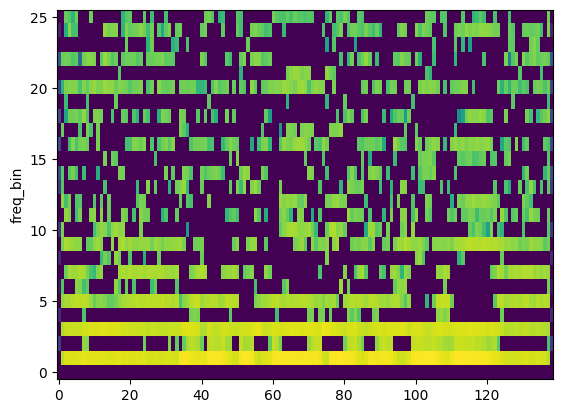

In [10]:

plot_spectrogram(dataset[4][0].T)